In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from datetime import datetime
import math
import cv2

In [2]:
T = 1000
max_noise = 0.02

betas = torch.linspace(0.001, max_noise, T)
alphas = 1-betas
alphas_cp = torch.cumprod(alphas, dim=0)

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
val_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

tensor(561)


Text(0.5, 1.0, '$\\hat{X_o}$')

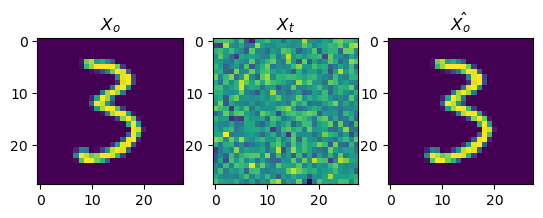

In [8]:
def generate_noised_img(x0: torch.Tensor, t: torch.Tensor):
    eps = torch.randn_like(x0)
    alpha_cp = alphas_cp[t.int().flatten()]
    xt = torch.sqrt(alpha_cp)[:, None, None, None] * x0 + torch.sqrt(1 - alpha_cp)[:, None, None, None] * eps

    return xt, eps


def denoise_img(xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
    if len(xt.shape) != 4:
        raise Exception(f"Expected Xt of shape B x C x H x W, got {xt.shape}")
    alpha_cp = alphas_cp[t.int().flatten()]
    return 1 / torch.sqrt(alpha_cp)[:, None, None, None] * (xt - torch.sqrt(1 - alpha_cp)[:, None, None, None] * eps)
    
def step_back(xt: torch.Tensor, t: torch.Tensor, eps_pred: torch.Tensor) -> torch.Tensor:
    if len(xt.shape) != 4:
        raise Exception(f"Expected Xt of shape B x C x H x W, got {xt.shape}")
        
    t = t.int().flatten()
    alpha = alphas[t][:, None, None, None]
    alpha_cp = alphas_cp[t][:, None, None, None]
    res = (1/torch.sqrt(alpha)) * (xt - (1-alpha) / torch.sqrt(1-alpha_cp) * eps_pred)
    
    if t <= 0:
        return res
    
    z = torch.randn_like(xt)
    std = torch.sqrt(betas[t])[:, None, None, None]
    return res + z * std


dummy_batch_x0, dummy_batch_labels = next(iter(train_loader))  # (B x 1 x 28 x 28), (B,)

t = torch.randint(0, T, size=(dummy_batch_x0.shape[0],))
dummy_batch_xt, dummy_batch_eps = generate_noised_img(dummy_batch_x0, t)
print(t[0])

denoised_img = denoise_img(dummy_batch_xt, t, dummy_batch_eps)

plt.subplot(131)
plt.imshow(dummy_batch_x0[0][0])
plt.title("$X_o$")

plt.subplot(132)
plt.imshow(dummy_batch_xt[0][0])
plt.title("$X_t$")

plt.subplot(133)
plt.imshow(denoised_img[0][0])
plt.title(r"$\hat{X_o}$")

# 🕒 Time Embedding in Diffusion Models

### 1. Why not `nn.Embedding`?
In Diffusion, the model needs to know exactly which timestep $t$ it is currently denoising. While a standard lookup table (`nn.Embedding`) works for discrete categories (like words), it fails here because:

* **Ordinal Relationships:** Standard embeddings treat $t=500$ and $t=501$ as completely independent.
* **Geometric Continuity:** Sinusoidal embeddings provide a "geometric progression" of frequencies. This allows the model to inherently understand that $t=500$ is "next to" $t=501$ and enables better generalization across the noise schedule.

### 2. The Mathematics
We map a scalar $t$ to a vector of dimension $d$ using pairs of sine and cosine waves:

$$Embedding(t, 2i) = \sin\left(\frac{t}{10000^{2i/d}}\right)$$
$$Embedding(t, 2i) = \cos\left(\frac{t}{10000^{2i + 1/d}}\right)$$


### 3. Implementation Tricks

1.  **Log Space:** We calculate the denominator as $exp( \frac{2i}{d} \cdot -\ln(10000) )$. This avoids calculating massive powers which can cause overflow.
2.  **Multiplication over Division:** We multiply $t$ by the inverse frequency for faster and more stable computation.

## 3. Injection Logic: The "Global Tint"
We don't just add the raw waves to the input image. To make the model "time-aware" at every level of abstraction, we follow these steps:

1.  **Time MLP:** The sinusoidal vector passes through a small MLP (Linear -> ReLU -> Linear) to create a learnable representation.
2.  **Projection:** Inside each U-Net block (Down, Up, Bottleneck), we use a `Linear` layer to match the time vector to the current block's channel count ($C_{out}$).
3.  **Broadcasting:** We reshape the vector from $(Batch, C_{out})$ to $(Batch, C_{out}, 1, 1)$.
4.  **Additive Injection:** We add it to the feature map: `x = x + t_projected`.

> **💡 Intuition:** This is like adding a "global tint" or "mood" to the feature maps. 
> * **High $t$ (High Noise):** The "tint" tells the model: "The image is pure chaos. Focus on finding global structure and ignore fine details."
> * **Low $t$ (Low Noise):** The "tint" tells the model: "The structure is already there. Focus on refining edges and removing the last bit of grain."

## 4. Critical Debugging Notes (Don't Forget!)
* **Avoid In-place Operations:** Never use `x += t`. This modifies the tensor in-place and breaks PyTorch's gradient history (it will crash with a `RuntimeError` during `loss.backward()`). Always use `x = x + t`.
* **Injection Point:** Inject time **after** the first convolution of a block but **before** the final activation/output of that block. This ensures the model has "spatial features" to mix the time signal into.
* **Bottleneck is Key:** Ensure the Bottleneck also receives the time embedding; otherwise, the model loses its "global strategy" at the most compressed layer.

In [115]:
class TimeEmbedding(nn.Module):
    def __init__(self, d):
        super().__init__()
        if d % 2 != 0:
            raise Exception("Dimension must be even")
        self.d = d
        
    def forward(self, t: torch.Tensor):
        # t (B x 1)
        t = t.view(-1, 1)
        
        exponent = torch.arange(0, self.d//2) / self.d
        den = torch.exp(-math.log(10e3) * exponent)
        
        args = torch.cat([torch.sin(t * den), torch.cos(t*den)], dim=1)
        return args

time_model = TimeEmbedding(d=8)
time_model(torch.tensor([1, 2, 3]))


tensor([[ 0.8415,  0.3110,  0.0998,  0.0316,  0.5403,  0.9504,  0.9950,  0.9995],
        [ 0.9093,  0.5911,  0.1987,  0.0632, -0.4161,  0.8066,  0.9801,  0.9980],
        [ 0.1411,  0.8126,  0.2955,  0.0947, -0.9900,  0.5828,  0.9553,  0.9955]])

In [ ]:
# Note that we pop from the skip blocks in a stack manner
# we have the bottle neck increasing our dimensionality so that when we start popping the dims will match
img_sz = 28
p_dropout = 0.3
time_emb_dim = 64


class DownBlock(nn.Module):
    def __init__(self, c_in, c_out) -> None:
        super().__init__()

        self.time_mlp = nn.Linear(time_emb_dim, c_out)
        self.c_out = c_out

        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )

        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_mlp(t).view(-1, self.c_out, 1, 1)
        x = self.conv1(x)
        x = x + t
        skip = self.conv2(x)
        return self.pool(skip), skip


class UpBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.c_out = c_out

        self.time_mlp = nn.Linear(time_emb_dim, c_out)

        self.up = nn.ConvTranspose2d(c_in, c_out, kernel_size=2, stride=2)

        self.conv1 = nn.Sequential(
            nn.Conv2d(c_out * 2, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t: torch.Tensor):
        t = self.time_mlp(t).view(-1, self.c_out, 1, 1)
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)

        x = self.conv1(x)
        x = x + t

        return self.conv2(x)


class BottleNeck(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.c_out = c_out

        self.time_mlp = nn.Linear(time_emb_dim, c_out)

        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=c_out),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=256),
            nn.GELU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=256),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t = self.time_mlp(t).view(-1, self.c_out, 1, 1)
        x = self.conv1(x)

        x = self.conv2(x + t)
        return self.conv3(x)


class UNet(nn.Module):
    def __init__(self, c_in):
        super().__init__()

        self.time_mlp = nn.Sequential(
            TimeEmbedding(64),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
        )

        self.down_blocks = nn.ModuleList(
            (
                DownBlock(c_in, 64),  # 28 -> 14
                DownBlock(64, 128),  # 14 -> 7
            )
        )

        self.bottleneck = BottleNeck(128, 256)

        self.up_blocks = nn.ModuleList(
            (
                UpBlock(256, 128),  # 7 -> 14
                UpBlock(128, 64),  # 14 -> 28
            )
        )

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x: torch.Tensor, t):
        t_embedded = self.time_mlp(t)

        skips = []
        for block in self.down_blocks:
            x, skip = block(x, t_embedded)
            skips.append(skip)

        x = self.bottleneck(x, t_embedded)

        for block in self.up_blocks:
            skip = skips.pop()
            x = block(x, skip, t_embedded)

        return self.final_conv(x)


model = UNet(1)
dummy_x = torch.rand(2, 1, 28, 28)
dummy_t = torch.randint(0, T, size=(2,))
model(dummy_x, dummy_t).shape

torch.Size([2, 1, 28, 28])

In [159]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter()
writer.add_graph(model, [dummy_x, dummy_t])
writer.close()

In [160]:
avg_train_losses = []
avg_val_losses = []

In [165]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [166]:
epochs = 5
grad_acumm_steps = 4

try:
    for epoch in range(epochs):
        avg_train_loss = 0

        model.train()
        train_bar = tqdm(train_loader, desc="Training")
        for i, (x0, label) in enumerate(train_bar):
            t = torch.randint(low=0, high=T, size=(x0.shape[0],))
            xt, eps = generate_noised_img(x0, t)

            eps_pred = model(xt, t)

            loss = criterion(eps_pred, eps)
            avg_train_loss += loss.item()
            loss.backward()

            if (i + 1) % grad_acumm_steps == 0:
                opt.step()
                opt.zero_grad()

            train_bar.set_postfix(loss=avg_train_loss / (i + 1))
            
            if i == 200:
                break
            
        avg_train_loss /= 200 # len(train_loader)
        with torch.no_grad():
            avg_val_loss = 0
            model.eval()
            val_bar = tqdm(val_loader, desc="Validation")
            for i, (x0, label) in enumerate(val_bar):
                t = torch.randint(low=0, high=T, size=(x0.shape[0],))
                xt, eps = generate_noised_img(x0, t)

                eps_pred = model(xt, t)

                loss = criterion(eps_pred, eps)
                avg_val_loss += loss.item()

                val_bar.set_postfix(loss=avg_val_loss / (i + 1))
                if i == len(val_loader) // 4:
                    break

            avg_val_loss /= len(val_loader) // 4

        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)

        print(f"EPOCH {epoch} | avg train loss {avg_train_loss:.2f} | avg val loss {avg_val_loss:.2f}")
        
except KeyboardInterrupt:
    print("couldn't wait lool")

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 0 | avg train loss 0.03 | avg val loss 0.03


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 1 | avg train loss 0.03 | avg val loss 0.03


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 2 | avg train loss 0.03 | avg val loss 0.02


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

couldn't wait lool


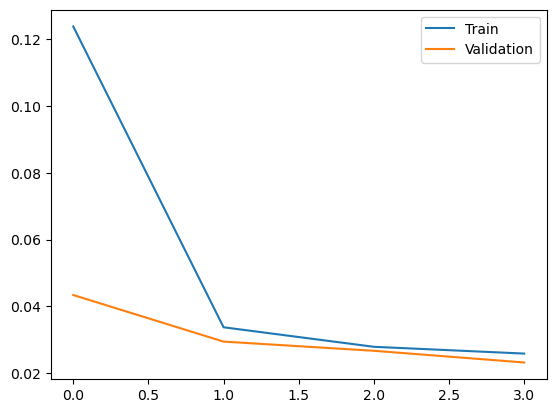

In [167]:
plt.plot(avg_train_losses, label="Train")
plt.plot(avg_val_losses, label="Validation")
plt.legend()

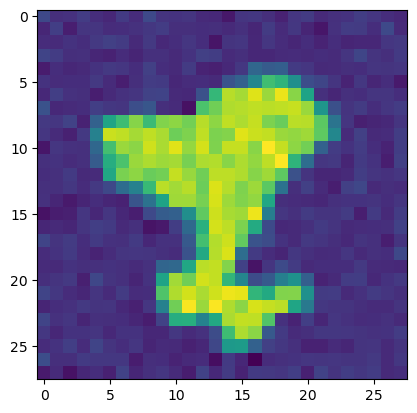

In [172]:
model.eval()
# img = torch.randn((1, 1, 28, 28))

for t in range(T - 1, -1, -1):
    t_tensor = torch.tensor([t])
    pred_noise = model(img, t_tensor)
    pred_noise = pred_noise.view(-1, 1, 28, 28)
    
    img = step_back(img, t_tensor, pred_noise)
    
    if t % 20 == 0:
        img_np = img.flatten(0, 2).detach().numpy()
        img_np = np.clip(img_np, 0, 1)
        img_np = cv2.resize(img_np, (240, 240))
        cv2.imshow("hoho", img_np)
        plt.show()
        if cv2.waitKey(1) == ord('q'):
            cv2.destroyAllWindows()
            break
        
cv2.destroyAllWindows()


plt.imshow(img[0][0].detach().numpy())


# 🎨 MNIST Diffusion: From Math to U-Net

This repository is a step-by-step implementation of Denoising Diffusion Probabilistic Models (DDPM). The goal is to understand the underlying Gaussian math, the forward noise process, and the neural architecture required to generate images from pure noise.

## 📖 Primary Reference
This project follows the logic and parameters established in the seminal paper:
* **Denoising Diffusion Probabilistic Models (DDPM)** by Ho et al. (2020).

---

## 🚀 Project Roadmap

The implementation is broken down into three logical stages:

### 1. In-Depth Inspection (`1_forward_process.ipynb`)
This notebook focuses on the **Forward Diffusion Process**. 
* **Mathematical Proof:** Verifies that jumping directly to any timestep $t$ using the $\alpha$ cumulative product is equivalent to the iterative looping approach of adding noise.
* **Variance Preservation:** Demonstrates how the $\sqrt{\alpha}$ scaling factor prevents variance from exploding, keeping the pixel values within a stable range ($std \approx 1$).
* **Noise Prediction:** Introduces the concept of training the model to predict the **noise ($\epsilon$)** added to an image rather than the image itself, and the derivation to recover $x_0$ from that prediction.

### 2. Proof of Concept: Custom MLP (`2_custom_mlp.ipynb`)
A transition from math to code using a simplified architecture.
* **Simpler Model:** Uses a basic Linear MLP to test if the "predict noise" logic works on flattened MNIST digits.
* **DDPM Sampling:** Implements the formal reverse-diffusion sampling formula to denoise images step-by-step, moving from pure Gaussian noise back to the data manifold.

### 3. The Full U-Net (`3_unet.ipynb`)
The final, production-grade architecture used in the DDPM paper.
* **U-Net Architecture:** Implements a convolutional encoder-decoder with skip connections to preserve spatial details.
* **Sinusoidal Time Embeddings:** Implements the "Clock of Diffusion"—a frequency-based embedding that allows the model to know the current timestep $t$ at every layer.
* **Context Injection:** Shows how to project and broadcast time embeddings into Downsample, Upsample, and Bottleneck blocks.

---

* Note: The final architecture isn't exact replicate of the papers unet architecture, which explains why the performance wasn't as good, the goal here is simply understanding not getting state of art performance